# Introduction
This notebook is a basic implementation of [Show and Tell: A Neural Image Caption Generator](https://arxiv.org/abs/1411.4555) by Oriol Vinyals et. al. In this paper the authors have suggested an end to end solution to an image caption generator. Previous to this paper, all that was proposed for this task involved independent task optimization (vision and natural language) and then a hand engineered stitching of theses independent tasks.

This paper takes its inspiration from Neural Machine Translation, where an encoder trains on a sequence in a given language and produces a **fixed length representation** for a decoder, that spits a sequence in another language. Stemming from this idea, the authors have used a vision feature extractor as the encoder and a sequence model as the decoder.
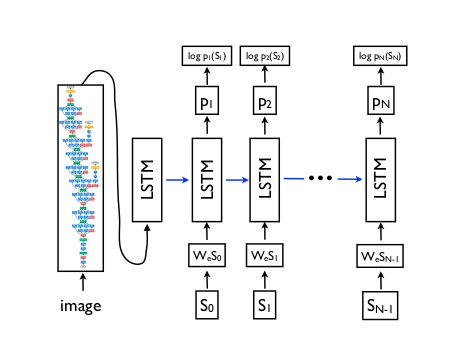

In [ ]:
!pip install --upgrade -q wandb

In [ ]:
! nvidia-smi

# Imports
The following packages are imported:
- tensorflow
- matplotlib
- numpy
- IPython


In [ ]:
import wandb

import tensorflow as tf
from tensorflow.keras.layers import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import IPython

# Data
- data_dir is the path to the images and the `results.csv`
- image_dir is the path exculsively to the images
- csv_file is the path to the `results.csv` file

In [ ]:
data_dir = '../input/flickr-image-dataset/flickr30k_images'
image_dir = f'{data_dir}/flickr30k_images'
csv_file = f'{data_dir}/results.csv'

Here we read the csv file as a dataframe and make some observations from it.
For a quick EDA we are going to 
- check the shape of the dataframe
- check the names of the columns
- find out the unique image names there are

In [ ]:
df = pd.read_csv(csv_file, delimiter='|')

print(f'[INFO] The shape of dataframe: {df.shape}')
print(f'[INFO] The columns in the dataframe: {df.columns}')
print(f'[INFO] Unique image names: {len(pd.unique(df["image_name"]))}')

A quick observation here is to see that the dataframe has `158915` elements but only `31783` image names. This means that there is a duplicacy involved. On further inspection we will see that each image has 5 unique captions attached to it ($31783\times 5=158915$)

While looking into the dataframe I found out that `19999` had some messed up entries. This has led me to manually change the entries in that row.

In [ ]:
df.columns = ['image_name', 'comment_number', 'comment']
del df['comment_number']

# Under scrutiny I had found that 19999 had a messed up entry
df['comment'][19999] = ' A dog runs across the grass .'

# Image names now correspond to the absolute position
df['image_name'] = image_dir+'/'+df['image_name']

# <start> comment <end>
df['comment'] = "<start> "+df['comment']+" <end>"

In [ ]:
# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)
df.head()

In [ ]:
SIZE = len(df)

train_size = int(0.7* SIZE) 
val_size = int(0.1* SIZE)
test_size = int(0.2* SIZE)

train_size, val_size, test_size

Splitting the dataframe accordingly

In [ ]:
train_df = df.iloc[:train_size,:]
val_df = df.iloc[train_size+1:train_size+val_size,:]
test_df = df.iloc[train_size+val_size+1:,:]

In [ ]:
# Enter different indices.
index = 200

image_name = train_df['image_name'][index]
comment = train_df['comment'][index]

print(comment)

IPython.display.Image(filename=image_name)

# Text Handling
- Defined the size of the vocab which is `5000`.
- Initialized the Tokenizer class.
    - Standardized (all to lower case)
    - Filters the punctuations
    - Splits the text
    - Creates the vocabulary (`<start>, <end> and <unk>` is defined)

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')

Here we fit the `tokenizer` object on the captions. This helps in the updation of the vocab that the `tokenizer` object might have.

In the first iteration the vocabulary does not start from `0`. Both the dictionaries have 1 as the key or value.

In [ ]:
# build the vocabulary
tokenizer.fit_on_texts(train_df['comment'])

In [ ]:
# This is a sanity check function
def check_vocab(word):
    i = tokenizer.word_index[word]
    print(f"The index of the word: {i}")
    print(f"Index {i} is word {tokenizer.index_word[i]}")
    
check_vocab("pajama")

Here we are padding the sentences so that each of the sentences are of the same length.

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_df['comment'])
val_seqs = tokenizer.texts_to_sequences(val_df['comment'])
test_seqs = tokenizer.texts_to_sequences(test_df['comment'])

In [ ]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
train_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
val_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(val_seqs, padding='post')
test_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(test_seqs, padding='post')

In [ ]:
# Caption vector
train_cap_vector.shape, val_cap_vector.shape, test_cap_vector.shape

In [ ]:
train_cap_ds = tf.data.Dataset.from_tensor_slices(train_cap_vector)
val_cap_ds = tf.data.Dataset.from_tensor_slices(val_cap_vector)
test_cap_ds = tf.data.Dataset.from_tensor_slices(test_cap_vector)

# Image Handling
- Load the image
- decode jpeg
- resize
- standardize

In [ ]:
@tf.function
def load_img(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (224, 224))
    return img

In [ ]:
train_img_name = train_df['image_name'].values
val_img_name = val_df['image_name'].values
test_img_name = test_df['image_name'].values

In [ ]:
train_img_ds = tf.data.Dataset.from_tensor_slices(train_img_name).map(load_img)
val_img_ds = tf.data.Dataset.from_tensor_slices(val_img_name).map(load_img)
test_img_ds = tf.data.Dataset.from_tensor_slices(test_img_name).map(load_img)

# Joint data

In [ ]:
# prefecth and batch the dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 512

train_ds = tf.data.Dataset.zip((train_img_ds, train_cap_ds)).shuffle(42).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_ds = tf.data.Dataset.zip((val_img_ds, val_cap_ds)).shuffle(42).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_ds = tf.data.Dataset.zip((test_img_ds, test_cap_ds)).shuffle(42).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

Sanity check for the division of datasets

In [ ]:
run = wandb.init(project="show-and-tell",
                 entity="collaborativeml",
                 name="ariG-devJ-img-cap",
                 save_code=False)

images = []
for img, cap in test_ds.take(1):
    batch_size = img.shape[0]
    for i in range(batch_size):
        text = []
        for c in cap[i]:
            if c.numpy() == 0:
                break
            text.append(tokenizer.index_word[c.numpy()])
        images.append(wandb.Image(img[i],
                                  caption=' '.join(text)))
run.log({"img":images})
run.finish()

## Model
### Show (Encoder)
- InceptionV3: This will act like the feature extractor
- Use an FC layer to extract the features of the image
- The features will be used as the initial hidden state for the RNN

### Tell (Decoder)
- The initial hidden state is used
- The text is embedded
- Usage of an LSTM to produce softmax on the vocab
- Loss with captions

In [ ]:
# Some global variables
EMBEDDIN_DIM = 512
VOCAB_SIZE = 10000
UNITS_RNN = 256

In [ ]:
class CNN_Encoder(tf.keras.Model):
    
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.embedding_dim = embedding_dim
        
    def build(self, input_shape):
        self.resnet = tf.keras.applications.ResNet50(include_top=False,
                                                     weights='imagenet')
        self.resnet.trainable=False
        self.gap = GlobalAveragePooling2D()
        self.fc = Dense(units=self.embedding_dim,
                        activation='sigmoid')
        
    def call(self, x):
        x = self.resnet(x)
        x = self.gap(x)
        x = self.fc(x)
        return x

In [ ]:
# Checking the CNN
encoder = CNN_Encoder(EMBEDDIN_DIM)
for image, caption in train_ds.take(1):
    print(encoder(image).shape)
    break

In [ ]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.embedding = Embedding(input_dim=self.vocab_size,
                                   output_dim=self.embedding_dim)
    
    def build(self, input_shape):
        self.gru1 = GRU(units=self.units,
                       return_sequences=True,
                       return_state=True)
        self.gru2 = GRU(units=self.units,
                       return_sequences=True,
                       return_state=True)
        self.gru3 = GRU(units=self.units,
                       return_sequences=True,
                       return_state=True)
        self.gru4 = GRU(units=self.units,
                       return_sequences=True,
                       return_state=True)
        self.fc1 = Dense(self.units)
        self.fc2 = Dense(self.vocab_size)

    def call(self, x, initial_zero=False):
        # x, (batch, 512)
        # hidden, (batch, 256)
        if initial_zero:
            initial_state = decoder.reset_state(batch_size=x.shape[0])
            output, state = self.gru1(inputs=x,
                                      initial_state=initial_state)
            output, state = self.gru2(inputs=output,
                                      initial_state=initial_state)
            output, state = self.gru3(inputs=output,
                                      initial_state=initial_state)
            output, state = self.gru4(inputs=output,
                                      initial_state=initial_state)
        else:
            output, state = self.gru1(inputs=x)
            output, state = self.gru2(inputs=output)
            output, state = self.gru3(inputs=output)
            output, state = self.gru4(inputs=output)
        # output, (batch, 256)
        x = self.fc1(output)
        x = self.fc2(x)
        
        return x, state
    
    def embed(self, x):
        return self.embedding(x)
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
# Checking the RNN
decoder = RNN_Decoder(embedding_dim=EMBEDDIN_DIM,
                      units=UNITS_RNN,
                      vocab_size=VOCAB_SIZE)
for image, caption in train_ds.take(1):
    features = tf.expand_dims(encoder(image),1) # (batch, 1, 128)
    em_words = decoder.embed(caption)
    x = tf.concat([features,em_words],axis=1)
    print(x.shape)
    predictions, state = decoder(x, True)
    print(predictions.shape)
    print(state.shape)

In [ ]:
encoder = CNN_Encoder(EMBEDDIN_DIM)
decoder = RNN_Decoder(embedding_dim=EMBEDDIN_DIM,
                      units=UNITS_RNN,
                      vocab_size=VOCAB_SIZE)

We use `Adam` as the optimizer.

The loss is `SparseCategoricalCrossentropy`, because here it would be inefficient to use one-hot-encoders are the ground truth. We will also use mask to help mask the `<pad>` so that we do not let the sequence model learn to overfit on the same.

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [ ]:
@tf.function
def train_step(img_tensor, target):
    # img_tensor (batch, 224,224,3)
    # target     (batch, 80)
    loss = 0
    with tf.GradientTape() as tape:
        features = tf.expand_dims(encoder(img_tensor),1) # (batch, 1, 128)
        em_words = decoder.embed(target)
        x = tf.concat([features,em_words],axis=1)
        predictions, _ = decoder(x, True)

        loss = loss_function(target[:,1:], predictions[:,1:-1,:])

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [ ]:
@tf.function
def val_step(img_tensor, target):
    # img_tensor (batch, 224,224,3)
    # target     (batch, 80)
    loss = 0
    features = tf.expand_dims(encoder(img_tensor),1) # (batch, 1, 128)
    em_words = decoder.embed(target)
    x = tf.concat([features,em_words],axis=1)
    predictions, _ = decoder(x, True)
    loss = loss_function(target[:,1:], predictions[:,1:-1,:])
    return loss

In [ ]:
from tqdm import tqdm

In [ ]:

EPOCHS = 15
epoch_wise_loss = []
epoch_wise_val_loss = []
for epoch in range(EPOCHS):
    batch_wise_loss = []
    for (batch, (img_tensor, target)) in enumerate(train_ds):
        loss = train_step(img_tensor, target)
        batch_wise_loss.append(loss.numpy())
        if batch%100 == 0:
            print(f'Epoch: {epoch} Batch: {batch} Loss: {batch_wise_loss[-1]:.3f}')
    epoch_wise_loss.append(np.mean(batch_wise_loss))
    
    batch_wise_val_loss = []
    for (batch, (img_tensor, target)) in enumerate(val_ds):
        loss = val_step(img_tensor, target)
        batch_wise_val_loss.append(loss.numpy())
    epoch_wise_val_loss.append(np.mean(batch_wise_val_loss))
    print(f'Epoch: {epoch} Total Loss: {epoch_wise_loss[-1]:.3f} Val Loss:{epoch_wise_val_loss[-1]:.3f}')
    print('-'*40)

In [ ]:
run = wandb.init(project="show-and-tell",
                 entity="collaborativeml",
                 name="ariG-devJ-model_train",
                 save_code=False)
with run:
    for idx,loss in enumerate(epoch_wise_loss):
        run.log({"Train_Loss":loss, "Epoch_Train":idx})
    for idx,loss in enumerate(epoch_wise_val_loss):
        run.log({"Val_Loss":loss, "Epoch_Val":idx})

Save the weights

In [ ]:
!mkdir models
encoder.save_weights('./models/encoder.h5')
decoder.save_weights('./models/decoder.h5')

# Inference
## Total Loss

In [ ]:
encoder = CNN_Encoder(EMBEDDIN_DIM)
for image, caption in train_ds.take(1):
    encoder(image)

decoder = RNN_Decoder(embedding_dim=EMBEDDIN_DIM,
                      units=UNITS_RNN,
                      vocab_size=VOCAB_SIZE)
for image, caption in train_ds.take(1):
    features = tf.expand_dims(encoder(image),1)
    em_words = decoder.embed(caption)
    x = tf.concat([features,em_words],axis=1)
    predictions, state = decoder(x, True)

encoder.load_weights('./models/encoder.h5')
decoder.load_weights('./models/decoder.h5')

In [ ]:
batch_loss = []
for (batch, (img_tensor, target)) in tqdm(enumerate(test_ds.take(10))):
    loss = val_step(img_tensor, target)
    batch_loss.append(loss.numpy())
print(f'Test Loss: {np.mean(batch_loss):.3f}')

In [ ]:
run = wandb.init(project="show-and-tell",
                 entity="collaborativeml",
                 name="ariG-devJ-models",
                 save_code=False)
with run:
    trained_model_artifact = wandb.Artifact("encoder_decoder",
                                            type="model",
                                            description="vision encoder and text decoder",)
    trained_model_artifact.add_dir('./models/')
    run.log_artifact(trained_model_artifact)

## Checking with an image

In [ ]:
img, cap = next(iter(test_ds.take(1)))

img[0].shape, cap[0].shape

In [ ]:
img = tf.expand_dims(img[0],0)
cap = tf.expand_dims(cap[0],0)

img.shape, cap.shape

In [ ]:
feature = tf.expand_dims(encoder(img),1) # (1, 1, 128)

feature.shape

In [ ]:
# For the image
prediction, _ = decoder(feature, True)
print(prediction.shape)

In [ ]:
word = tf.reshape(tokenizer.word_index['<start>'], shape=(1,1))
em_words = decoder.embed(word)
print(em_words.shape)

prediction, _ = decoder(em_words)
idx = tf.random.categorical(tf.squeeze(prediction,1), 1)[0][0].numpy()
word = tokenizer.index_word[idx]
print(word)

In [ ]:
count = 0
while word != '<end>':
    print(word, end=" ")
    if count > 100:
        break
    word_int = tf.reshape(tokenizer.word_index[word], shape=(1,1))  
    em_words = decoder.embed(word_int)
    prediction, _ = decoder(em_words)
    idx = tf.random.categorical(tf.squeeze(prediction,1), 1)[0][0].numpy()
    word = tokenizer.index_word[idx]
    count += 1

plt.imshow(img[0])
plt.show()